## Email NLP
#### Final project data science course


## Part 2 
previous part of the 3_4 part

part 2
num of features is 2294
score is: 1.0
[[25  0  0  0  0]
 [ 0 32  0  0  0]
 [ 0  0 95  0  0]
 [ 0  0  0 52  0]
 [ 0  0  0  0 27]]
LR: 0.941486 (0.029299)


C:\Users\Ben\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Ben\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


LDA: 0.804971 (0.059945)
KNN: 0.813406 (0.047450)
CART: 0.902565 (0.043191)
NB: 0.874828 (0.042343)
SVM: 0.554759 (0.071386)


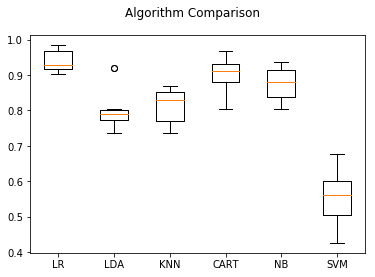

done


In [2]:
import csv
import gensim
import re
from gensim import corpora, models
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import random
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import sys




def buildAndCleanCSV(fileName,sendersArray):
    dictionariesOfSenders={}
    allWordsOfSenders={}
    row_count=0
    for sender in sendersArray:
        dictionariesOfSenders[sender]=[]

    with open(fileName+'.csv', 'rb') as csv_file:
        csv.field_size_limit(sys.maxint)
        reader = csv.reader(csv_file)
        row_count = sum(1 for row in reader)
    with open(fileName+'.csv', 'rb') as csv_file:
        csv.field_size_limit(sys.maxint)
        reader = csv.reader(csv_file)
        current_row=1
        line = next(reader, None)
        while (line):
            if current_row % 1000==0:
                print('row is: '+str(current_row)+'/'+str(row_count))
            # Remove HTML
            text = BeautifulSoup(line[1], "html.parser").get_text()
            #  Remove non-letters and words longer than 3 letters
            letters_only = re.sub("[^a-zA-Z]", " ", text)
            letters_only = ' '.join(word for word in letters_only.split() if len(word) > 2)
            #lower letters
            letters_only = letters_only.lower()
            # Convert to lower case, split into individual words
            words = letters_only.split()
            # a list, so convert the stop words to a set (faster)
            stops = set(stopwords.words("english"))
            emailStopWords = {'Additional', 'option' ,'for', 'viewing',' and', 'saving', 'the', 'attached', 'documents','http','mass','bgu','ac' ,'il', 'nm', 'php' ,'mm' ,'b' ,'cfe' ,'a','Website', 'www', 'bgu','attachments', 'view', 'npdf', 'pdf', 'alternative', 'view','save', 'additional'}
            # Remove stop words
            meaningful_words = [w for w in words if not w in stops]
            meaningful_words = [w for w in meaningful_words if not w in emailStopWords]
            # 6. Join the words back into one string separated by space and return the result.
            words_combined=" ".join(meaningful_words)
            #stemming
            #porter = nltk.PorterStemmer()
            #[porter.stem(w) for w in words_combined]
            #taking only emails with more than 50 characters to avoid non-informative emails
            if(len(words_combined)>30):
                dictionariesOfSenders[line[0]].append(words_combined.split())
            line = next(reader, None)
            current_row+=1
    sendersBOWlength=[]
    for sender in sendersArray:
        combined=[]
        for tmp in dictionariesOfSenders[sender]:
            combined=combined+tmp
        allWordsOfSenders[sender]=set(combined)
        #BOW size will be the number of different words and if its above 5000, max size will be set to 5000
        sendersBOWlength.append(len(allWordsOfSenders[sender]) if len(allWordsOfSenders[sender])<=5000 else 5000)
    #creating the bag of words
    # Initialize the "CountVectorizer" object, which is scikit-learn's
    # bag of words tool.
    sendersVectorizers_featureNames={}
    sendersVectorizers_arrays={}
    sendersVectorizers_models={}
    #combine all clean emails from all
    combined_y_label=[]
    text_representation = []
    for sender in sendersArray:
        for emailWordsList in dictionariesOfSenders[sender]:
            combined_y_label.append(sender)
            text_representation.append(" ".join(emailWordsList))
    #vectorizing, we chose max_features to be the max size of the BOW texts length or if higher than 5000 the size will be set to 5000
    num_of_features=max(sendersBOWlength)
    print('num of features is '+str(num_of_features))
    sendersVectorizers= CountVectorizer(analyzer="word", \
                             tokenizer=None, \
                             preprocessor=None, \
                             stop_words=None, \
                             max_features=num_of_features)
    #reading the new prediction test part to have the same number of features
    (pred_data_test_x,pred_data_test_y)=readPredData(senderlist)
    #merging test and train for the vectorization
    merged_list=text_representation+pred_data_test_x
    #sendersVectorizers_model = sendersVectorizers.fit_transform(text_representation)
    sendersVectorizers_model = sendersVectorizers.fit_transform(merged_list)
    sendersVectorizers_arrays=sendersVectorizers_model.toarray()
    # seperate train and test
    train_index=len(text_representation)
    #test needs to be 30% of the size of the train
    test_index=int(train_index*0.3)
    splitted_train_data=sendersVectorizers_arrays[:train_index]
    splitted_test_data=sendersVectorizers_arrays[train_index:]
    #creating the random forest classifier
    train_data_for_all_x=splitted_train_data
    train_data_for_all_y=combined_y_label
    #shuffle the test arrays and choose only 30%
    c2 = list(zip(splitted_test_data, pred_data_test_y))
    random.shuffle(c2)
    splitted_test_data, pred_data_test_y = zip(*c2)
    splitted_test_data=splitted_test_data[:test_index]
    pred_data_test_y=pred_data_test_y[:test_index]
    #shuffle the arrays
    c = list(zip(train_data_for_all_x, train_data_for_all_y))
    random.shuffle(c)
    train_data_for_all_x, train_data_for_all_y = zip(*c)
    # split to train & test
    x_train, x_test, y_train, y_test = train_test_split(train_data_for_all_x, train_data_for_all_y, test_size=0.2)

    # Initialize a Random Forest classifier with 100 trees
    forest = RandomForestClassifier(n_estimators = 100)
    # Fit the forest to the training set, using the bag of words as
    # features and the sentiment labels as the response variable
    #
    # This may take a few minutes to run
    forest = forest.fit( x_train, y_train )
    #joblib.dump(forest, 'model.pkl', compress=9)

    y_test_pred=forest.predict(splitted_test_data)
    # Evaluate accuracy best on the test set
    print('score is: ' +str(forest.score(splitted_test_data,pred_data_test_y)))
    #the confusion matrix of the senders of the test data (for random forest):
    print(str(confusion_matrix(pred_data_test_y, y_test_pred)))
    #comparing more models:
    import matplotlib.pyplot as plt
    from sklearn import model_selection
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.naive_bayes import GaussianNB
    from sklearn.svm import SVC
    # prepare configuration for cross validation test harness
    seed = 7
    # prepare models
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))
    # evaluate each model in turn
    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

    print('done')
def readPredData(senderlist):
    dictionariesOfSenders = {}
    text_representation_senders = []
    y_labels_representation_senders=[]
    row_count = 0
    for sender in senderlist:
        dictionariesOfSenders[sender] = []
        with open(sender + '_pred.csv', 'rb') as csv_file:
            csv.field_size_limit(sys.maxint)
            reader = csv.reader(csv_file)
            line = next(reader, None)
            while (line):
                pred_email = line[0]
                # Remove HTML
                text = BeautifulSoup(pred_email, "html.parser").get_text()
                #  Remove non-letters and words longer than 3 letters
                letters_only = re.sub("[^a-zA-Z]", " ", text)
                letters_only = ' '.join(word for word in letters_only.split() if len(word) > 2)
                # lower letters
                letters_only = letters_only.lower()
                # Convert to lower case, split into individual words
                words = letters_only.split()
                # a list, so convert the stop words to a set (faster)
                stops = set(stopwords.words("english"))
                emailStopWords = {'Additional', 'option', 'for', 'viewing', ' and', 'saving', 'the', 'attached',
                                  'documents', 'http', 'mass', 'bgu', 'ac', 'il', 'nm', 'php', 'mm', 'b', 'cfe', 'a',
                                  'Website', 'www', 'bgu', 'attachments', 'view', 'npdf', 'pdf', 'alternative', 'view',
                                  'save', 'additional'}
                # Remove stop words
                meaningful_words = [w for w in words if not w in stops]
                meaningful_words = [w for w in meaningful_words if not w in emailStopWords]
                # 6. Join the words back into one string separated by space and return the result.
                words_combined = " ".join(meaningful_words)
                dictionariesOfSenders[sender].append(words_combined.split())
                line = next(reader, None)

            combined_y_label = []
            text_representation = []
            for emailWordsList in dictionariesOfSenders[sender]:
                combined_y_label.append(sender)
                text_representation.append(" ".join(emailWordsList))
            text_representation_senders=text_representation_senders+text_representation
            y_labels_representation_senders=y_labels_representation_senders+combined_y_label
    return (text_representation_senders,y_labels_representation_senders)
#main
print('part 2')

#nltk.download()
senderlist = ['dean@bgu.ac.il', 'peler@exchange.bgu.ac.il', 'bitahon@bgu.ac.il', 'career@bgu.ac.il',
              'shanigu@bgu.ac.il']
#we decided to use the code from part two with the trained data
#because we needed the features number to be the same as in the training data
#so we used the new predicted data as the test data.
#we also used this part methods because we wanted the data to be precessed with the same preprocessing
buildAndCleanCSV('filteredBySendersTranslated',senderlist)

## Final part
 

In [3]:
import csv
import sys

import itertools

from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import random
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
import numpy as np
from keras.layers.recurrent import SimpleRNN
from keras.models import model_from_json
from collections import Counter
import re
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import random


def createModels(fileName,senderlist):
    #read and seperate each sender
    with open(fileName+'.csv', 'rb') as csv_file:
        csv.field_size_limit(sys.maxint)
        reader = csv.reader(csv_file)
        sendersWords = {}
        for k in range(0, len(senderlist)):
            sendersWords[senderlist[k]] = []
        line = next(reader, None)
        while (line):
            sender = line[0]
            splitEmail = line[1];
            sendersWords[sender].append(splitEmail)
            line = next(reader, None)
        #starting working with keras to create the model for each sender
        for k in range(0, len(senderlist)):
            senderEmailsArr=sendersWords[senderlist[k]];
            model = Sequential()
            n_hidden = 256
            n_fac = 42
            input_list=[]
            output_list=[]
            #list for each sentence with first word and number of words
            first_word_list=[]
            allEmails=""
            for email in senderEmailsArr:
                allEmails=allEmails+email+"--"
                emailSplit=email.split(" ")
                firstWord=""
                for i in range(0,len(emailSplit)):
                    if (emailSplit[i]!=''):
                        firstWord=emailSplit[i]
                        break
                first_word_list.append((firstWord, len(emailSplit)))
            allEmails=allEmails[:-2]
            vocabulary_size = 800
            unknown_token = "UNKNOWNTOKEN"
            sentence_start_token = "SENTENCESTART"
            sentence_end_token = "SENTENCEEND"
            line_break = "NEWLINE"
            separator = "SEPARATOR"
            emailText = allEmails.replace('\n', ' ' + line_break + ' ')
            emailText = emailText.replace('--', ' ' + separator + ' ')
            emailText = emailText.replace('.', ' ' + sentence_end_token + ' ' + sentence_start_token + ' ')
            emailText = re.sub(r'\d+', '', emailText)
            emailTextSeq = text_to_word_sequence(emailText, lower=True, split=" ")  # using only 10000 first words

            token = Tokenizer(nb_words=vocabulary_size, char_level=False)
            token.fit_on_texts(emailTextSeq)
            text_mtx = token.texts_to_matrix(emailTextSeq, mode='binary')
            input_ = text_mtx[:-1]
            output_ = text_mtx[1:]
            print('input shape is: '+str(input_.shape)+' output shape is: '+ str(output_.shape))
            #training the model
            model.add(Embedding(input_dim=input_.shape[1], output_dim=42, input_length=input_.shape[1]))
            model.add(Flatten())
            model.add(Dense(output_.shape[1], activation='sigmoid'))
            model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])
            model.fit(input_, y=output_, batch_size=500, nb_epoch=50, verbose=1, validation_split=0.2)
            saveModelToFile(model, senderlist[k])
            with open(senderlist[k] + '_pred.csv', 'wb') as result_csv_file:
                writer = csv.writer(result_csv_file)
                for pred_email in first_word_list:
                    pred_text=""
                    nextWord=separator
                    for i in range(0,pred_email[1]):
                        if(i==vocabulary_size-1):
                            break
                        try:
                            pred_word=get_next(nextWord, token, model, text_mtx, emailTextSeq)
                            pred_text=pred_text+" "+pred_word
                            nextWord=pred_word
                        except ValueError:
                            print nextWord
                        if (nextWord == separator):
                            break
                    writer.writerow([pred_text])
            # evaluate the model
            #scores = model.evaluate(input_, output_, verbose=0)
            #print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
            saveModelToFile(model,senderlist[k])


def loadModelFromFile(name):
    # load json and create model
    json_file = open(name+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])
    # load weights into new model
    loaded_model.load_weights(name+".h5")
    print("Loaded model from disk")
    return loaded_model

def saveModelToFile(model,name):
    # serialize model to JSON
    model_json = model.to_json()
    with open(name+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(name+".h5")
    print("Saved model to disk")
#a function to predict the next word
def get_next(text,token,model,fullmtx,fullText):
    tmp = text_to_word_sequence(text, lower=True, split=" ")
    tmp = token.texts_to_matrix(tmp, mode='binary')
    p = model.predict(tmp)
    bestMatch = np.min(np.argmax(p))
    options=np.where(fullmtx[:,bestMatch]>0)[0]
    smart_rand_pos=random.randint(0,len(options)-1)
    next_idx = smart_rand_pos
    return fullText[next_idx]

def readClassifier(file_name):
    return joblib.load(file_name)


def read_random_parts(file_name, percentage):
    lines = sum(1 for line in open(file_name)) #number of records in file (excludes header)
    print lines
    C = int(lines * (percentage/100.0)) #sample size (percentage%)
    buffer = []
    f = open(file_name, 'r')
    for line_num, line in enumerate(f):
        n = line_num + 1.0
        r = random.random()
        if n <= C:
            buffer.append(line.strip())
        elif r < C/n:
            loc = random.randint(0, C-1)
            buffer[loc] = line.strip()
    return buffer

def evaluateTheModel(fileName,senderlist):
    # read and seperate each sender
    with open(fileName + '.csv', 'rb') as csv_file:
        csv.field_size_limit(sys.maxint)
        reader = csv.reader(csv_file)
        sendersWords = {}
        for k in range(0, len(senderlist)):
            sendersWords[senderlist[k]] = []
        line = next(reader, None)
        while (line):
            sender = line[0]
            splitEmail = line[1];
            sendersWords[sender].append(splitEmail)
            line = next(reader, None)
        # starting working with keras to create the model for each sender
        for k in range(0, len(senderlist)):
            senderEmailsArr = sendersWords[senderlist[k]];
            model = Sequential()
            n_hidden = 256
            n_fac = 42
            input_list = []
            output_list = []
            # list for each sentence with first word and number of words
            first_word_list = []
            allEmails = ""
            for email in senderEmailsArr:
                allEmails = allEmails + email + "--"
                emailSplit = email.split(" ")
                firstWord = ""
                for i in range(0, len(emailSplit)):
                    if (emailSplit[i] != ''):
                        firstWord = emailSplit[i]
                        break
                first_word_list.append((firstWord, len(emailSplit)))
            allEmails = allEmails[:-2]
            vocabulary_size = 800
            unknown_token = "UNKNOWNTOKEN"
            sentence_start_token = "SENTENCESTART"
            sentence_end_token = "SENTENCEEND"
            line_break = "NEWLINE"
            separator = "SEPARATOR"
            emailText = allEmails.replace('\n', ' ' + line_break + ' ')
            emailText = emailText.replace('--', ' ' + separator + ' ')
            emailText = emailText.replace('.', ' ' + sentence_end_token + ' ' + sentence_start_token + ' ')
            emailText = re.sub(r'\d+', '', emailText)
            emailTextSeq = text_to_word_sequence(emailText, lower=True, split=" ")  # using only 10000 first words

            token = Tokenizer(nb_words=vocabulary_size, char_level=False)
            token.fit_on_texts(emailTextSeq)
            text_mtx = token.texts_to_matrix(emailTextSeq, mode='binary')
            input_ = text_mtx[:-1]
            output_ = text_mtx[1:]
            print('input shape is: ' + str(input_.shape) + ' output shape is: ' + str(output_.shape))
            # training the model
            model=loadModelFromFile(senderlist[k])
            #evaluate the model
            scores = model.evaluate(input_, output_, verbose=0)
            print("sender "+senderlist[k]+ " accuracy is: ")
            print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

#main
senderlist=['dean@bgu.ac.il','peler@exchange.bgu.ac.il','bitahon@bgu.ac.il','career@bgu.ac.il','shanigu@bgu.ac.il']
#createModels('filteredBySendersTranslated',senderlist)
#the accuracy of the model checked with cross validation of 0.2 and saved on the model, after trying to change the features values, the values that
#are we chose to use, are fitted to out data and our resources (cpu, memory, etc...)
evaluateTheModel('filteredBySendersTranslated',senderlist)
print('done.')

C:\Users\Ben\Anaconda2\lib\site-packages\keras\preprocessing\text.py:139: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


input shape is: (32669L, 800L) output shape is: (32669L, 800L)
Loaded model from disk
sender dean@bgu.ac.ilaccuracy is: 
acc: 41.08%
input shape is: (15154L, 800L) output shape is: (15154L, 800L)
Loaded model from disk
sender peler@exchange.bgu.ac.ilaccuracy is: 
acc: 36.87%
input shape is: (13010L, 800L) output shape is: (13010L, 800L)
Loaded model from disk
sender bitahon@bgu.ac.ilaccuracy is: 
acc: 52.85%
input shape is: (21304L, 800L) output shape is: (21304L, 800L)
Loaded model from disk
sender career@bgu.ac.ilaccuracy is: 
acc: 41.03%
input shape is: (11071L, 800L) output shape is: (11071L, 800L)
Loaded model from disk
sender shanigu@bgu.ac.ilaccuracy is: 
acc: 57.30%
done.


#### Some notes:
##### Input / output examples:
input: (real email)
We would like to inform you that as of today, Sunday, the Chumusia Delali is closed until the end of the tender process."

output: (email of the same sender with the model)
additional his fund for ac of months does there students' married il the david french french the of nis are underwood who income sorekay economic students 


more raw emails on filteredBySendersTranslated.csv file.
and sender outputs are on <name>_pred.csv file

Link to download (too big for github):
https://mega.nz/#!P1E32KZQ!k5ecRYt5ih4djz8pYvDXpC5dzkfbCkIpXD8M6N0Ca3s

this link contains also the the model files
instead build the model, there is a function that load it from a file

Previous parts repositories:
https://github.com/BenEfrati/ex1/tree/master/email-nlp
https://github.com/BenEfrati/ex1/tree/master/email-nlp2